# HR Analytics: Employee Retention

Goals of this mini project:

1. to investigate what reasons potentially made the employees of a company leave their jobs in the past;
2. to build a model that can accurately predict when other employees are about to leave the company due to dissatisfaction.

Needless to say that this kind of information can be very useful for any company, since it helps spotting management deficiencies and avoiding expenses related to employee turnover, among other benefits.

For this task, a data set containing information about ~15000 employees was used. Different learning algorithms are applied to build the predictive models, and their results are evaluated in terms of sensibility, specificity and the area under the Receiver Operating Characteristic (ROC) curve.

In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(corrplot))
suppressMessages(library(caret))

## 1 Data load

In [2]:
# The data set is in CSV format.
df <- read.csv('raw_data.csv')

In [3]:
# Get the size of the data set.
dim(df)

[1] 14999    12

In [4]:
# Basic description.
str(df)

'data.frame':	14999 obs. of  12 variables:
 $ name                  : Factor w/ 14999 levels "AARON","ABAD",..: 12684 6923 14613 1753 6933 9378 3296 4951 11577 14631 ...
 $ satisfaction_level    : num  0.38 0.8 0.11 0.72 0.37 0.41 0.1 0.92 0.89 0.42 ...
 $ last_evaluation       : num  0.53 0.86 0.88 0.87 0.52 0.5 0.77 0.85 1 0.53 ...
 $ number_projects       : int  2 5 7 5 2 2 6 5 5 2 ...
 $ average_monthly_hours : int  157 262 272 223 159 153 247 259 224 142 ...
 $ time_spent_company    : int  3 6 4 5 3 3 4 5 5 3 ...
 $ work_accident         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ left                  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ promotion_last_5_years: int  0 0 0 0 0 0 0 0 0 0 ...
 $ department            : Factor w/ 10 levels "accounting","hr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ salary                : Factor w/ 3 levels "high","low","medium": 2 3 3 2 2 2 2 2 2 2 ...
 $ salary_level          : int  1 2 2 1 1 1 1 1 1 1 ...


In [5]:
# Min, max, mean, median, quartiles and frequencies.
summary(df)

      name       satisfaction_level last_evaluation  number_projects
 AARON  :    1   Min.   :0.0900     Min.   :0.3600   Min.   :2.000  
 ABAD   :    1   1st Qu.:0.4400     1st Qu.:0.5600   1st Qu.:3.000  
 ABALOS :    1   Median :0.6400     Median :0.7200   Median :4.000  
 ABARCA :    1   Mean   :0.6128     Mean   :0.7161   Mean   :3.803  
 ABATE  :    1   3rd Qu.:0.8200     3rd Qu.:0.8700   3rd Qu.:5.000  
 ABBAS  :    1   Max.   :1.0000     Max.   :1.0000   Max.   :7.000  
 (Other):14993                                                      
 average_monthly_hours time_spent_company work_accident         left       
 Min.   : 96.0         Min.   : 2.000     Min.   :0.0000   Min.   :0.0000  
 1st Qu.:156.0         1st Qu.: 3.000     1st Qu.:0.0000   1st Qu.:0.0000  
 Median :200.0         Median : 3.000     Median :0.0000   Median :0.0000  
 Mean   :201.1         Mean   : 3.498     Mean   :0.1446   Mean   :0.2381  
 3rd Qu.:245.0         3rd Qu.: 4.000     3rd Qu.:0.0000   3rd Qu.:0

In [6]:
# Count missing values.
sapply(df, function(x) { sum(is.na(x)) })

name     satisfaction_level        last_evaluation 
                     0                      0                      0 
       number_projects  average_monthly_hours     time_spent_company 
                     0                      0                      0 
         work_accident                   left promotion_last_5_years 
                     0                      0                      0 
            department                 salary           salary_level 
                     0                      0                      0

In [7]:
# First 5 observations.
head(df)

name,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,work_accident,left,promotion_last_5_years,department,salary,salary_level
SMITH,0.38,0.53,2,157,3,0,1,0,sales,low,1
JOHNSON,0.80,0.86,5,262,6,0,1,0,sales,medium,2
WILLIAMS,0.11,0.88,7,272,4,0,1,0,sales,medium,2
BROWN,0.72,0.87,5,223,5,0,1,0,sales,low,1
JONES,0.37,0.52,2,159,3,0,1,0,sales,low,1
MILLER,0.41,0.50,2,153,3,0,1,0,sales,low,1


In [8]:
# Last 5 observations.
tail(df)

,name,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,work_accident,left,promotion_last_5_years,department,salary,salary_level
14994,ARTER,0.76,0.83,6,293,6,0,1,0,support,low,1
14995,WELDY,0.40,0.57,2,151,3,0,1,0,support,low,1
14996,VINTON,0.37,0.48,2,160,3,0,1,0,support,low,1
14997,SALIBA,0.37,0.53,2,143,3,0,1,0,support,low,1
14998,PARMAR,0.11,0.96,6,280,4,0,1,0,support,low,1
14999,OSTLER,0.37,0.52,2,158,3,0,1,0,support,low,1


So the data set contains exactly 14999 observations and each is described by 12 features:

* `name`: employee's last name.
* `satisfaction_level`: employee's satisfaction, as a 0-1 score.
* `last_evaluation`: employee's score in the last evaluation, as a 0-1 score.
* `number_projects`: number of projects the employee has worked on.
* `average_monthly_hours`: average working hours per month.
* `time_spent_company`: how long (years) the employee works at the company.
* `work_accident`: values 1 if the employee has had any work accident, and 0 otherwise.
* `left`: values 1 if the employee has left the company, and 0 otherwise.
* `promotion_last_5_years`: values 1 if the employee has received a promotion in the last 5 years, and 0 otherwise.
* `department`: department the employee works in.
* `salary`: employee's salary level ("low", "medium", "high").
* `salary_level`: employee's salary level as a number (1, 2, 3).

There are no missing values to be filled.

`left` is the target variable.

In [9]:
df.copy1 <- df

In [10]:
# Represent categorical features as factors, and drop unnecessary features.
df <- df %>%
    mutate(work_accident = as.factor(work_accident)) %>%
    mutate(left = as.factor(left)) %>%
    mutate(promotion_last_5_years = as.factor(promotion_last_5_years)) %>%
    mutate(salary = factor(salary, levels = c('low', 'medium', 'high'), ordered = T)) %>%
    subset(select = -c(name, salary_level))

In [11]:
str(df)

'data.frame':	14999 obs. of  10 variables:
 $ satisfaction_level    : num  0.38 0.8 0.11 0.72 0.37 0.41 0.1 0.92 0.89 0.42 ...
 $ last_evaluation       : num  0.53 0.86 0.88 0.87 0.52 0.5 0.77 0.85 1 0.53 ...
 $ number_projects       : int  2 5 7 5 2 2 6 5 5 2 ...
 $ average_monthly_hours : int  157 262 272 223 159 153 247 259 224 142 ...
 $ time_spent_company    : int  3 6 4 5 3 3 4 5 5 3 ...
 $ work_accident         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ left                  : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ promotion_last_5_years: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ department            : Factor w/ 10 levels "accounting","hr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ salary                : Ord.factor w/ 3 levels "low"<"medium"<..: 1 2 2 1 1 1 1 1 1 1 ...


## 2 Exploratory data analysis

In [12]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
# Source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)
#
multiplot <- function(..., plotlist = NULL, file, cols = 1, layout = NULL) {
    library(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # If layout is NULL, then use 'cols' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of cols
        layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                         ncol = cols, nrow = ceiling(numPlots/cols))
    }

    if (numPlots == 1) {
        print(plots[[1]])
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

            print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                            layout.pos.col = matchidx$col))
        }
    }
}

In [13]:
# Feature names.
names.categorical <- c('work_accident', 'promotion_last_5_years', 'department', 'salary')
names.numerical <- c('satisfaction_level', 'last_evaluation', 'number_projects', 'average_monthly_hours', 'time_spent_company')

### 2.1 Marginal feature distributions

#### `left`

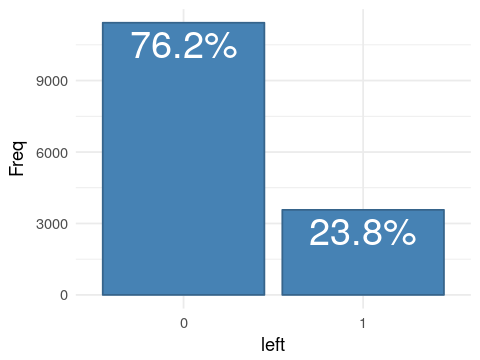

In [14]:
options(repr.plot.width = 4, repr.plot.height = 3)

df.left <- as.data.frame(table(df$left))
df.left <- mutate(df.left, left = Var1, Prop = Freq / sum(Freq))

ggplot(df.left, aes(x = left, y = Freq)) +
    geom_bar(stat = 'identity', colour = 'steelblue4', fill = 'steelblue') +
    geom_text(aes(label = paste0(100 * round(Prop, 3), '%')),
              vjust = 1.25, size = 8, colour = 'white') +
    theme_minimal()

About 23.8% of all employees in the dataset left the company.

#### Continuous features

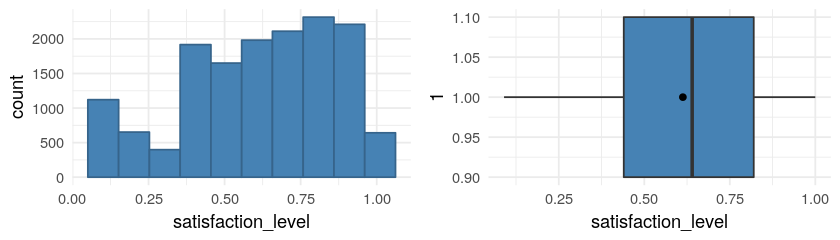

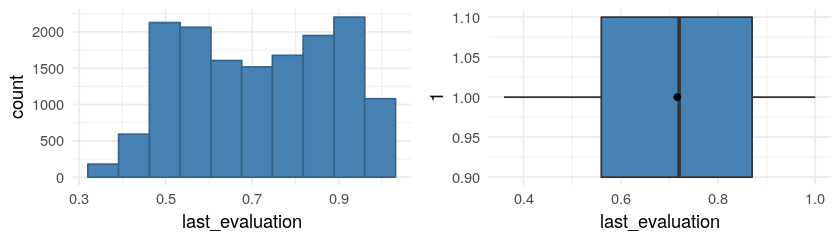

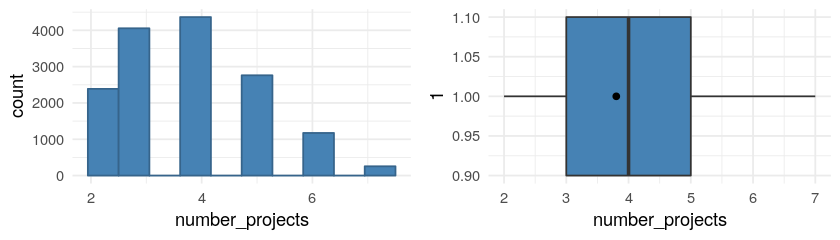

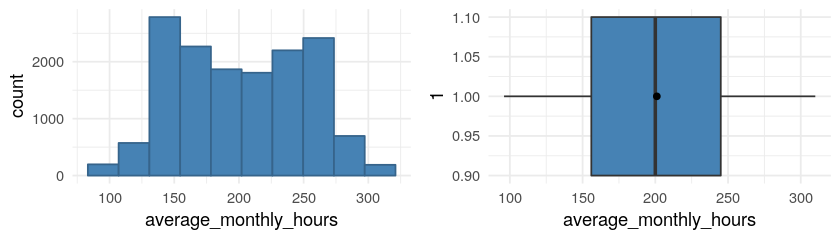

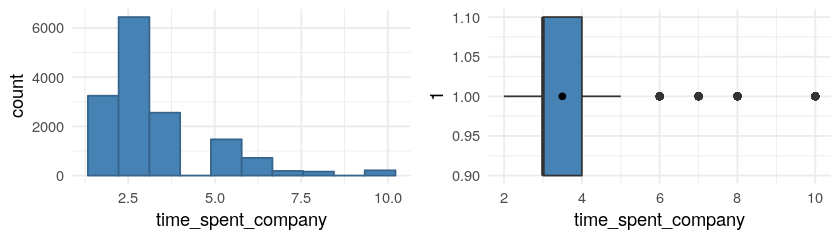

In [15]:
options(repr.plot.width = 7, repr.plot.height = 2)

for (x in names.numerical) {
    g1 <- ggplot(df, aes_string(x = x)) +
        geom_histogram(bins = 10, colour = 'steelblue4', fill = 'steelblue') +
        theme_minimal()

    g2 <- ggplot(df, aes_string(x = '1', y = x)) +
        geom_boxplot(fill = 'steelblue', width = 0.2) +
        stat_summary(fun.y = mean, geom = 'point') +
        coord_flip() +
        theme_minimal()

    multiplot(g1, g2, cols = 2)
}

The average employee satisfaction level in this company is about 0.6. Most values concentrate between 0.44 and 0.82. **Question:** how exactly does this satisfaction level correlate to the likelihood that an employee will leave the company?

In the last evaluation, most employees score between 0.5 and 0.9. The minimum score was 0.3. **Question:** are these employees with lower scores the most likely to leave the company?

Employees may work on up to 7 projects. Most work on 3-5, and the minimum amount is 2. **Question:** how does the number of projects an employee works on correlate to their satisfaction level and salary? Are they well paid? Does that reflect their engagement in the company? Or could it be an indicator of overwork?

There are employees who work less than 150 hours per month, and others that work more than 250 hours per month. **Question:** again, could the extreme cases indicate overwork? Are these employees that work too much a relevant portion of those who left the company?

The vast majority of employees leave the company in less than 5 years (average is around 3 years). So this company has a high turnover rate. **Question:** how much time the employees who have left the company used to spend there, in average?

#### Categorical features

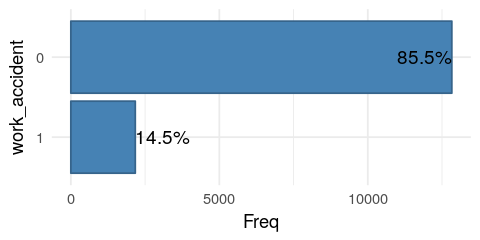

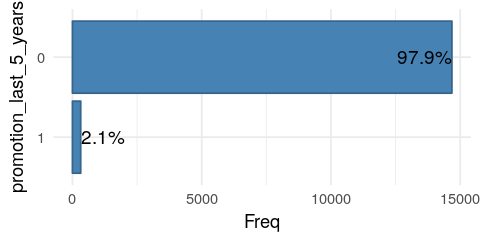

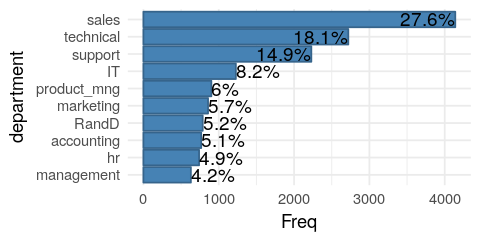

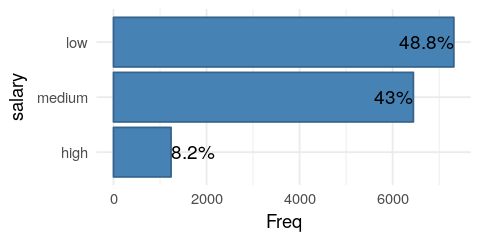

In [16]:
options(repr.plot.width = 4, repr.plot.height = 2)

for (x in names.categorical) {
    df.x <- as.data.frame(table(df[, x]))
    df.x <- mutate(df.x, Var1 = reorder(Var1, Freq), Prop = Freq / sum(Freq))
    colnames(df.x) <- c(x, 'Freq', 'Prop')

    g <- ggplot(df.x, aes_string(x = x, y = 'Freq')) +
        geom_bar(stat = 'identity', colour = 'steelblue4', fill = 'steelblue') +
        geom_text(aes(label = paste0(100 * round(Prop, 3), '%')),
                  hjust = 'inward', size = 4) +
        coord_flip() +
        theme_minimal()

    print(g)
}

Some conclusions and further questions:

About 14.5% of the employees had already suffered some work accident. **Question:** could these accidents influence the likelihood that an employee will leave the company?

Only 2.1% of all employees have had any promotion in the last 5 years. **Question:** could this lack of recognition in the workplace be one of the main reasons for employees leaving the company in just a few years?

The sales team is the one with most collaborators. **Question:** are employees from specific departments more likely to leave the company, indicating that there could be some management problem in these departments?

The vast majority of employees receive low or medium salaries. **Question:** could a lower salary be another good predictor of employee dissatisfaction? How important is the salary to keep employees in the company?

### 2.2 Feature correlations

In [17]:
# Multiple correlation test function.
#
# Computes tests for association/correlation between paired samples
# represented in the rows and columns of a matrix.
#
# Source: https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html
#
cor.mtest <- function(mat, conf.level = 0.95){
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- lowCI.mat <- uppCI.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    diag(lowCI.mat) <- diag(uppCI.mat) <- 1
    for(i in 1:(n-1)){
        for(j in (i+1):n){
            tmp <- cor.test(mat[,i], mat[,j], conf.level = conf.level)
            p.mat[i,j] <- p.mat[j,i] <- tmp$p.value
            lowCI.mat[i,j] <- lowCI.mat[j,i] <- tmp$conf.int[1]
            uppCI.mat[i,j] <- uppCI.mat[j,i] <- tmp$conf.int[2]
        }
    }
    return(list(p.mat, lowCI.mat, uppCI.mat))
}

In [18]:
df.cor <- subset(df.copy1, select = -c(name, department, salary))

In [19]:
# Perform pairwise correlation tests and get the p-values.
p.mat <- cor.mtest(df.cor)[[1]]

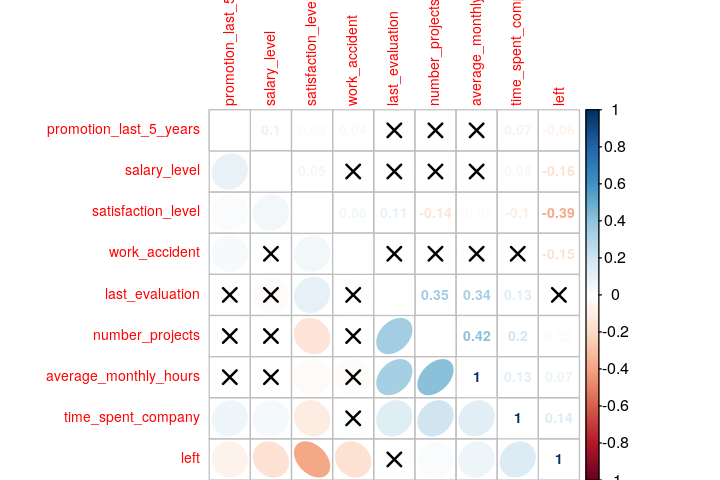

In [20]:
# Plot the correlation matrix.
options(repr.plot.width = 6, repr.plot.height = 4)

corrplot.mixed(cor(df.cor),
               lower = 'ellipse',
               upper = 'number',
               order = 'hclust',
               p.mat =  p.mat,
               sig.level = 0.05,
               tl.pos = 'lt',
               tl.cex = 0.7,
               number.cex = 0.7,
               pch.cex = 1.5)

The only feature that has a significant (negative) correlation to the target variable is (not surprisingly) `satisfaction_level`. That is, where we find dissatisfied employees there is a higher rate of employees leaving the company. `salary_level` and `work_accident` are negatively correlated to the target too, but in a weaker degree. `time_spent_in_company` has a weak positive correlation to the target (it is easier to find employees who left among those that work in the company for more time).

An employee's last evaluation score is more positively correlated to their average monthly hours and to the number of projects they worked on (and these two variables are positively correlated too: the more projects, the more monthly hours at work). But such evaluation score is irrelevant in predicting the target variable.

`promotion_last_5_years` does not correlate significantly with any other feature. This may be due to the fact that we have too few cases of promoted employees in the data set.

### 2.3 Joint feature distributions

## 3 Preprocessing

## 4 Model training

## 5 Results